### Pre-train BERT
* c09k_BERT_pretrain 코드에 이어, max_length를 512로 늘려서 pretrain 추가 수행
* https://www.thepythoncode.com/article/pretraining-bert-huggingface-transformers-in-python
* https://huggingface.co/transformers/v3.2.0/training.html

#### 이전 pre-train 결과에서 512로 늘려서 학습한 결과
* validation loss가 더 이상 떨어지지 않고 overfit되었고, 분류 성능도 나아지지 않았다.
* 학습 데이터 가공 과정에서 group_texts 함수를 적용하지 않은 데이터를 사용해 학습 결과를 관찰해보자
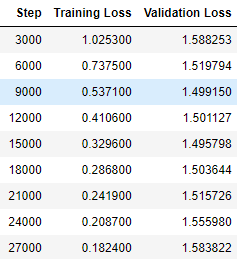
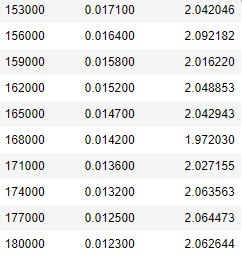

* 문장을 일정 길이 이상으로 병합 하는 로직을 해제하여 데이터셋에 짧은 문장도 포함된 상태로 돌린 결과
* overfit 되는 경향은 그대로 다시 나타남, c09k 전체 서브클래스의 특허 17만건을 다운받아서 pre-train을 다시 돌려보자
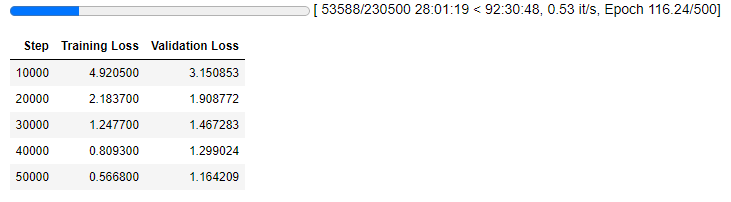

In [2]:
import os
import json
import time
import re
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import *
from tokenizers import *
from datasets import *
from sklearn.model_selection import train_test_split
import nltk
from nltk.data import load
import pickle

### Tokenizer train data 생성
* 약어 이후에 등장하는 마침표를 사용해 문장이 분리되지 않도록 조치를 해야 한다.
* NLTK의 tokenizer를 사용해 문장 분리하기 위해 extra_abbreviations에 예외조건을 추가하여 준다.
* 클린징이 끝난 데이터는 토크나이저 학습에 바로 사용하고, 이 데이터에서 테스트셋을 분리하여 pre-train 데이터로 사용예정
    * https://cryptosalamander.tistory.com/140?category=1218889

In [3]:
sent_tokenizer = load("tokenizers/punkt/english.pickle")
extra_abbreviations = [
    'RE','re','pat', 'no', 'nos','vol','jan','feb','mar','apr','jun',
    'jul','aug','sep','oct','nov','dec','eng','ser','ind','ed','pp',
    'e.g','al','T.E.N.S', 'E.M.S','F.E','U.H.T.S.T','degree',
    '/gm','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O',
    'P','Q','R','S','T','U','V','W','X','Y','Z']
sent_tokenizer._params.abbrev_types.update(extra_abbreviations)

In [4]:
# NLTK의 tokenizer를 사용해 문장 분리(미사용)
# https://cryptosalamander.tistory.com/140?category=1218889
def sent_tokenize(input='./input.txt', output='./output.txt'):
    sent_tokenizer = load("tokenizers/punkt/english.pickle")
    extra_abbreviations = [
        'RE','re','pat', 'no', 'nos','vol','jan','feb','mar','apr','jun',
        'jul','aug','sep','oct','nov','dec','eng','ser','ind','ed','pp',
        'e.g','al','T.E.N.S', 'E.M.S','F.E','U.H.T.S.T','degree',
        '/gm','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O',
        'P','Q','R','S','T','U','V','W','X','Y','Z']
    sent_tokenizer._params.abbrev_types.update(extra_abbreviations)

    load_file=open(input,'r')
    save_file=open(output,'w')
    no_blank = False
    while True:
        line = load_file.readline()
        if line == "":
            break
        if line.strip() == "":
            if no_blank:
                continue
            save_file.write(f"{line}")
        else:
            print(line)
            result_ = tokenizer.tokenize(line)
            print(result_)
            result  = [ f"{cur_line}\n" for cur_line in result_ ]
            for save_line in result:
                save_file.write(save_line)

In [5]:
try:
    dataset = Dataset.from_text('data/c09k_corpus.txt')
except:
    kiwee_files = ['data/c09k_0001-1000.xlsx', 'data/c09k_1001-2000.xlsx', 'data/c09k_2001-3000.xlsx', 'data/c09k_3001-3935.xlsx']
    with open('data/c09k_corpus.txt', 'a') as f:
        f.truncate(0)
        for i, fn in enumerate(kiwee_files):
            tmp = pd.read_excel(fn).fillna('')
            # pandas는 비어있는 컬럼의 dtype을 float로 바꿔서 인식한다. 그로 인해 토크나이징 할 데이터가 없으면 오류가 발생되어 fillna를 사용해 모두 텍스트로 인식시키도록 한다
            # https://stackoverflow.com/questions/53953286/pandas-read-excel-blanks-in-string-columns-convert-to-floats-converting-via-st
            col_text = ['발행번호', '발명의명칭', '요약', '대표청구항', '과제', '해결방안']
            tmp = tmp[col_text]
            for index, row in tmp.iterrows():
        #         print(index, '\n', row['발명의명칭'], row['요약'], row['대표청구항'], row['과제'], row['해결방안'], '\n')
                for col in col_text[1:]:
        #             print('처리중인 데이터:', col, row[col], '\n')
                    if row[col].strip() == "":
                        pass
                    else:
        #                 print(row[col].strip())
                        row[col] = unicodedata.normalize('NFKC', row[col])
                        # row[col] = unicodedata.normalize('NFC', row[col])  # 자음과 모음이 깨질 때는 NFC로 변환
                        # NFD(Normalization Form Decomposition) : 자음과 모음이 분리
                        # row[col] = unicodedata.normalize('NFKD', row[col])
                        #     https://blog.naver.com/PostView.nhn?blogId=duswl0319&logNo=221516880642&from=search&redirect=Log&widgetTypeCall=true&directAccess=false
                        row[col] = row[col].replace('\n\t',' ')
                        row[col] = row[col].replace('\n',' ')
                        row[col] = row[col].replace('&lt;',' ')
                        row[col] = row[col].replace('_x000d_',' ')
                        row[col] = row[col].replace('\t\t',' ')
                        row[col] = row[col].replace('@@',' ')
                        row[col] = row[col].replace('.  .','.')
                        row[col] = row[col].replace('. .','.')
                        row[col] = row[col].replace('..','.')
                        row[col] = row[col].replace('〜','~')
                        row[col] = row[col].replace(' . ','.')
                        row[col] = row[col].replace(' ． ','.')
                        row[col] = row[col].replace('． ','.')
                        row[col] = row[col].replace('. ','.')
                        row[col] = row[col].replace('  ',' ')
                        row[col] = row[col].replace('  ',' ')
                        row[col] = row[col].replace('【과제】',' ')
                        row[col] = row[col].replace('【요약】',' ')
                        row[col] = row[col].replace('【해결 수단】',' ')
                        str_tmp = sent_tokenizer.tokenize(row[col].strip())
        #                 print('문장 분리: ', str_tmp, '\n'*3)
        #                 result  = [f"{line}\n" for line in str_tmp]
                        for line in str_tmp:
                            f.write(f"{line}\n")
    dataset = Dataset.from_text('data/c09k_corpus.txt')

### 학습 데이터 분리/로딩

In [6]:
try:
    with open('data/c09k_dataset.pkl','rb') as f:
        d = pickle.load(f)
    print('dataset loading completed')
except:
    d = dataset.train_test_split(test_size=0.1)
    with open('data/c09k_dataset.pkl','wb') as f:
        pickle.dump(d, f)
    print('dataset split/saving completed')    

dataset loading completed


In [7]:
# # d["train"], d["test"]
# for t in d["train"]["text"][:3]:
#     print(t)
#     print("="*50)

In [8]:
# special_tokens = [
#   "[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]", "<S>", "<T>"
# ]
# # if you want to train the tokenizer on both sets
# # files = ["train.txt", "test.txt"]
# # training the tokenizer on the training set
# files = ["data/c09k_corpus.txt"]
# # 30,522 vocab is BERT's default vocab size, feel free to tweak
# vocab_size = 8000
# # maximum sequence length, lowering will result to faster training (when increasing batch size)
# max_length = 512
# # whether to truncate
# truncate_longer_samples = False

In [9]:
model_path = "c09k_pretrained_bert"
vocab_size = 8000
max_length = 512
truncate_longer_samples = False

### Pre-train data 생성

In [10]:
# dumping some of the tokenizer config to config file, 
# including special tokens, whether to lower case and the maximum sequence length
with open(os.path.join(model_path, "config.json"), "w") as f:
    tokenizer_cfg = {"do_lower_case": True,
                     "unk_token": "[UNK]",
                     "sep_token": "[SEP]",
                     "pad_token": "[PAD]",
                     "cls_token": "[CLS]",
                     "mask_token": "[MASK]",
                     "model_max_length": max_length,
                     "max_len": max_length,
                    }
    json.dump(tokenizer_cfg, f)

### Tokenizing the Dataset

In [11]:
# when the tokenizer is trained and configured, load it as BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained(model_path, vocab_size=8000, local_files_only=True)
# tokenizer = BertTokenizer.from_pretrained(model_path, )

loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file c09k_pretrained_bert/config.json
Model config BertConfig {
  "_name_or_path": "c09k_pretrained_bert",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "cls_token": "[CLS]",
  "do_lower_case": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "mask_token": "[MASK]",
  "max_len": 512,
  "max_position_embeddings": 512,
  "model_max_length": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token": "[PAD]",
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "sep_token": "[SEP]",
  "transformers_version": "4.22.0.dev0",
  "type_vocab_size": 2,
  "unk_token": "[UNK]",
  "use_cache": true,
  "vocab_size": 30522
}



vocab_file vocab.txt
tokenizer_file tokenizer.json
added_tokens_file added_tokens.json
special_tokens_map_file special_tokens_map.json
tokenizer_config_file tokenizer_config.json


In [14]:
# ?tokenizer

In [15]:
def encode_with_truncation(examples):
    """Mapping function to tokenize the sentences passed with truncation"""
    return tokenizer(examples["text"], truncation=True, padding=True,
                                     max_length=max_length, return_special_tokens_mask=True)

def encode_without_truncation(examples):
    """Mapping function to tokenize the sentences passed without truncation"""
    return tokenizer(examples["text"], return_special_tokens_mask=True)

In [16]:
# the encode function will depend on the truncate_longer_samples variable
# encode = encode_with_truncation if truncate_longer_samples else encode_without_truncation
encode = encode_with_truncation

In [17]:
# tokenizing the train dataset
train_dataset = d["train"].map(encode, batched=True)
# tokenizing the testing dataset
test_dataset = d["test"].map(encode, batched=True)

100%|██████████| 15/15 [00:02<00:00,  5.77ba/s]


In [18]:
# test_dataset['text']

In [19]:
# print(train_dataset[:2])
len(train_dataset)  # 14769

14769

In [20]:
if truncate_longer_samples:
    # remove other columns and set input_ids and attention_mask as PyTorch tensors
    train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
    test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
else:
    # remove other columns, and remain them as Python lists
    test_dataset.set_format(columns=["input_ids", "attention_mask", "special_tokens_mask"])
    train_dataset.set_format(columns=["input_ids", "attention_mask", "special_tokens_mask"])

In [21]:
from itertools import chain
# Main data processing function that will concatenate all texts from our dataset and generate chunks of max_seq_length.
# grabbed from: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py

In [22]:
# max_length = 64

In [23]:
# maxlen=512로 학습한 결과가 성능이 좋지 않아, 그룹텍스트 함수를 적용하지 않고 다시 pre-train을 시도
# def group_texts(examples):
#     # Concatenate all texts.
#     concatenated_examples = {k: list(chain(*examples[k])) for k in examples.keys()}
#     total_length = len(concatenated_examples[list(examples.keys())[0]])
#     # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
#     # customize this part to your needs.
#     if total_length >= max_length:
#         total_length = (total_length // max_length) * max_length
#     # Split by chunks of max_len.
#     result = {
#         k: [t[i : i + max_length] for i in range(0, total_length, max_length)]
#         for k, t in concatenated_examples.items()
#     }
#     return result

In [24]:
# # Note that with `batched=True`, this map processes 1,000 texts together, so group_texts throws away a
# # remainder for each of those groups of 1,000 texts. You can adjust that batch_size here but a higher value
# # might be slower to preprocess.
# #
# # To speed up this part, we use multiprocessing. See the documentation of the map method for more information:
# # https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.map
# if not truncate_longer_samples:
#     train_dataset1 = train_dataset.map(group_texts, batched=True,
#                                                                         desc=f"Grouping texts in chunks of {max_length}")
#     test_dataset1 = test_dataset.map(group_texts, batched=True,
#                                                                     desc=f"Grouping texts in chunks of {max_length}")
#     # convert them from lists to torch tensors
#     train_dataset1.set_format("torch")
#     test_dataset1.set_format("torch")

In [25]:
# train_dataset.set_format("torch")
# test_dataset.set_format("torch")

In [26]:
len(train_dataset), len(test_dataset)  # (14769, 1642)
# len(train_dataset1), len(test_dataset1)  # (2171, 225)

(14769, 1642)

In [27]:
len(train_dataset['input_ids'][1])

512

In [28]:
# # Dataset({
# #     features: ['text', 'input_ids', 'token_type_ids', 'attention_mask', 'special_tokens_mask'],
# #     num_rows: 14769
# # })
# len(train_dataset['special_tokens_mask'][1])

In [29]:
for i in range(2):
    print(train_dataset['input_ids'][i])
    print(tokenizer.decode(train_dataset['input_ids'][i]))

[37, 1075, 1198, 39, 891, 7003, 16, 6244, 2185, 3629, 3826, 1623, 447, 300, 428, 750, 398, 2129, 1185, 7661, 2781, 16, 2969, 547, 414, 5272, 401, 2338, 7140, 2159, 645, 595, 616, 551, 16, 863, 1527, 389, 960, 676, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Loading the Model

In [30]:
vocab_size

8000

In [32]:
# initialize the data collator, randomly masking 20% (default is 15%) of the tokens for the Masked Language
# Modeling (MLM) task
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

### Pre-Training - Additional

In [33]:
# load the model checkpoint  : 8.30 실행 코드, max_len = 64로 학습된 모델을 로드하여 512로 변경 후 추가 학습
# model = BertForMaskedLM.from_pretrained(os.path.join(model_path, "checkpoint-7500"))  # max_len = 64로 pre-train한 모델 로드 (8.22 완료)
# model.config.max_length = 512  # 512로 추가 학습하기 위해 모델 설정 변경

In [34]:
load_chk = ['c09k_pretrained_bert', 'checkpoint-7500']
save_chk = ['c09k_pretrained_bert_512_3', '']
tok_chk = ['c09k_pretrained_bert', '']

In [35]:
# model_config = BertConfig(vocab_size=vocab_size, max_position_embeddings=max_length)
model = BertForMaskedLM.from_pretrained(os.path.join(load_chk[0], load_chk[1]))  # max_len = 512로 추가 pre-train한 모델 로드 (8.30 완료)
# model.config.max_length = 512  # 512로 추가 학습하기 위해 모델 설정 변경
# model.config.max_position_embeddings = 512  # 512로 추가 학습하기 위해 모델 설정 변경
model_config = BertConfig(vocab_size=vocab_size, max_length=max_length, max_position_embeddings=max_length)
model = BertForMaskedLM(config=model_config)
model

loading configuration file c09k_pretrained_bert/checkpoint-7500/config.json
Model config BertConfig {
  "_name_or_path": "c09k_pretrained_bert/checkpoint-4320",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 64,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.22.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 8000
}

loading weights file c09k_pretrained_bert/checkpoint-7500/pytorch_model.bin
All model checkpoint weights were used when initializing BertForMaskedLM.

All the weights of BertForMaskedLM were initialized from the model checkpoint at c09k_pretrained_

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [36]:
# # initialize the model with the config
# model_config = BertConfig(vocab_size=vocab_size, max_position_embeddings=max_length)
# model = BertForMaskedLM(config=model_config)

In [37]:
# model

In [38]:
# load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained(tok_chk[0], vocab_size=8000, local_files_only=True)

loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file c09k_pretrained_bert/config.json
Model config BertConfig {
  "_name_or_path": "c09k_pretrained_bert",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "cls_token": "[CLS]",
  "do_lower_case": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "mask_token": "[MASK]",
  "max_len": 512,
  "max_position_embeddings": 512,
  "model_max_length": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token": "[PAD]",
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "sep_token": "[SEP]",
  "transformers_version": "4.22.0.dev0",
  "type_vocab_size": 2,
  "unk_token": "[UNK]",
  "use_cache": true,
  "vocab_size": 30522
}



vocab_file vocab.txt
tokenizer_file tokenizer.json
added_tokens_file added_tokens.json
special_tokens_map_file special_tokens_map.json
tokenizer_config_file tokenizer_config.json


In [39]:
fill_mask = pipeline("fill-mask", model=model, tokenizer=tokenizer)

In [40]:
# # perform predictions
# # 인광성 유기 금속 이리듐 착체, 발광 소자, 발광 장치, 전자 기기, 및 조명 장치
# # 본 명세서는 화학식 1로 표시되는 화합물 및 이를 포함하는 유기 발광 소자에 관한 것이다
# examples = [
#     "인광성 유기 금속 이리듐 착체, [MASK] 소자, 발광 장치, 전자 기기, 및 조명 장치",
#     "본 명세서는 화학식 1로 표시되는 [MASK] 및 이를 포함하는 유기 발광 소자에 관한 것이다",
#     "인광성 유기 금속 이리듐 착체, 발광 소자, 발광 장치, [MASK] 기기, 및 조명 장치",
#     "본 명세서는 화학식 1로 표시되는 화합물 및 이를 포함하는 [MASK] 발광 소자에 관한 것이다",
# ]
# for example in examples:
#     print(fill_mask(example))
#     for prediction in fill_mask(example):
#         print(f"{prediction['sequence']}, confidence: {prediction['score']}")
#     print("="*50)

In [41]:
# Num examples = 19400
# Num Epochs = 50
# Total optimization steps = 3750 = 750*50 = 
# 로드한 모델 추가학습
training_args = TrainingArguments(
    output_dir=save_chk[0],          # output directory to where save model checkpoint
    evaluation_strategy="steps",    # 'steps': evaluate each `logging_steps`, 'epoch'  : each epoch
    overwrite_output_dir=False,     # 원래 True였으나 변경 (8.30) 
    num_train_epochs=500,            # number of training epochs, feel free to tweak
    per_device_train_batch_size=8, # the training batch size, put it as high as your GPU memory fits
    gradient_accumulation_steps=4,  # accumulating the gradients before updating the weights
    per_device_eval_batch_size=8,  # evaluation batch size
    logging_steps=10000,             # evaluate, log and save model checkpoints every 1000 step
    save_steps=10000,
    resume_from_checkpoint=True,  # 체크포인트를 이어서 학습 가능할지 확인을 위해 새로 추가(8.30)
    load_best_model_at_end=True,  # whether to load the best model (in terms of loss) at the end of training
#     save_total_limit=5,           # whether you don't have much space so you let only 3 model weights saved in the disk
)

using `logging_steps` to initialize `eval_steps` to 10000
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [44]:
%%time
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

CPU times: user 3.6 ms, sys: 0 ns, total: 3.6 ms
Wall time: 2.81 ms


In [43]:
import time
import datetime # datetime 라이브러리 import

In [45]:
%%time
trainer.train()
#  max_len=64 로드하여 epochs=10, logging_steps=50, save_steps=900,
# load_chk = ['c09k_pretrained_bert', 'checkpoint-7500']
# save_chk = ['c09k_pretrained_bert_512_3', '']
# tok_chk = ['c09k_pretrained_bert', '']
# [ 7/4610 00:09 < 2:20:59, 0.54 it/s, Epoch 0.01/10]

The following columns in the training set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text, special_tokens_mask. If text, special_tokens_mask are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
/home/hdh/PycharmProjects/bert_pretrain/venv/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 14769
  Num Epochs = 500
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 230500


Step,Training Loss,Validation Loss
10000,4.920500,3.150853
20000,2.183700,1.908772
30000,1.247700,1.467283
40000,0.809300,1.299024
50000,0.566800,1.164209


The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text, special_tokens_mask. If text, special_tokens_mask are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1642
  Batch size = 8
Saving model checkpoint to c09k_pretrained_bert_512_3/checkpoint-10000
Configuration saved in c09k_pretrained_bert_512_3/checkpoint-10000/config.json
Model weights saved in c09k_pretrained_bert_512_3/checkpoint-10000/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text, special_tokens_mask. If text, special_tokens_mask are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1642
  Batch size = 8
Saving model checkpoint to c09k_pretrained_bert_512_3/checkpoint-20000
Configurat

KeyboardInterrupt: 

### Masked-LM 성능 확인
* 모델과 토크나이저를 한번은 로드 해줘야 하네. 그렇지 않으면 토크나이저가 CPU에 로드되어 있는 것으로 인식하여 에러 발생

In [56]:
# load the model checkpoint
model1 = BertForMaskedLM.from_pretrained(os.path.join('c09k_pretrained_bert_512', "checkpoint-7000"))
# load the tokenizer
# tokenizer = BertTokenizerFast.from_pretrained(model_path)
tokenizer1 = BertTokenizerFast.from_pretrained(model_path, vocab_size=8000, local_files_only=True)
fill_mask = pipeline("fill-mask", model=model1, tokenizer=tokenizer1)
# perform predictions
# 인광성 유기 금속 이리듐 착체, 발광 소자, 발광 장치, 전자 기기, 및 조명 장치
# 본 명세서는 화학식 1로 표시되는 화합물 및 이를 포함하는 유기 발광 소자에 관한 것이다
examples = [
    "인광성 유기 금속 이리듐 착체, [MASK] 소자, 발광 장치, 전자 기기, 및 조명 장치",
    "본 명세서는 화학식 1로 표시되는 [MASK] 및 이를 포함하는 유기 발광 소자에 관한 것이다",
    "인광성 유기 금속 이리듐 착체, 발광 소자, 발광 장치, [MASK] 기기, 및 조명 장치",
    "본 명세서는 화학식 1로 표시되는 화합물 및 이를 포함하는 [MASK] 발광 소자에 관한 것이다",
]
for example in examples:
    print(fill_mask(example))
    for prediction in fill_mask(example):
        print(f"{prediction['sequence']}, confidence: {prediction['score']}")
    print("="*50)

loading configuration file c09k_pretrained_bert_512/checkpoint-7000/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.22.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 8000
}

loading weights file c09k_pretrained_bert_512/checkpoint-7000/pytorch_model.bin
All model checkpoint weights were used when initializing BertForMaskedLM.

All the weights of BertForMaskedLM were initialized from the model checkpoint at c09k_pretrained_bert_512/checkpoint-7000.
If your task is similar 

vocab_file vocab.txt
tokenizer_file tokenizer.json
added_tokens_file added_tokens.json
special_tokens_map_file special_tokens_map.json
tokenizer_config_file tokenizer_config.json
[{'score': 0.06595180928707123, 'token': 16, 'token_str': ',', 'sequence': '인광성 유기 금속 이리듐 착체,, 소자, 발광 장치, 전자 기기, 및 조명 장치'}, {'score': 0.06593338400125504, 'token': 678, 'token_str': '유기', 'sequence': '인광성 유기 금속 이리듐 착체, 유기 소자, 발광 장치, 전자 기기, 및 조명 장치'}, {'score': 0.04995021969079971, 'token': 805, 'token_str': '금속', 'sequence': '인광성 유기 금속 이리듐 착체, 금속 소자, 발광 장치, 전자 기기, 및 조명 장치'}, {'score': 0.01198280043900013, 'token': 450, 'token_str': '전기', 'sequence': '인광성 유기 금속 이리듐 착체, 전기 소자, 발광 장치, 전자 기기, 및 조명 장치'}, {'score': 0.01068327110260725, 'token': 412, 'token_str': '및', 'sequence': '인광성 유기 금속 이리듐 착체, 및 소자, 발광 자

### 그 외 참고용 자료

In [ ]:
# 명선 책임의 문장 분리 코드(3글자 이후 마침표가 등장하는 경우에 간혹 분리되는 경우가 있다. 미사용)
# REG_SENT_KO=r'([ㄱ-ㅣ가-힣]+[.]|[\n]|[:;!?])'
# REG_SENT_EN=r'([a-zA-Z]+[.]\s|[\n]|[:;!?])'

# def split_sentence(doc, regex):
#     s = 0
#     for m in re.finditer(regex, doc):
#         sent = doc[s:m.end()].strip()
#         s = m.end()
#         if not sent:
#             continue
#         yield sent

#     if s < len(doc):
#         sent = doc[s:].strip()
#         if sent:
#             yield sent

### using personal dataset
* https://huggingface.co/docs/datasets/dataset_script

In [ ]:
# # if you have huge custom dataset separated into files
# # load the splitted files
# files = ["train1.txt", "train2.txt"] # train3.txt, etc.
# dataset = load_dataset("text", data_files=files, split="train")

### 문장 클린징 처리 전/후 비교

In [8]:
print(dataset['text'][0:5])
print(dataset['text'][-5:])
# 문장 클린징 처리 전
# ['이산화티탄-염화리튬 전기변색물질, 이를 이용한전기변색장치용 파우더 및 필름전극의 제조방법', '본 발명은 이산화티탄-염화리튬 전기변색물질 및 이를 이용한 전기변색장치용 파우더 및 필름전극의 제조방법에 관한 것으로, 이산화티탄에 염화리튬이 균일하게 혼합된 물질을 합성하여 제조되며 상기 이산화티탄-염화리튬에서 티탄 대 리튬의 몰 함량 비율이 1 : x (0.5 &lt; x &lt; 2) 범위를 갖는 이산화티탄-염화리튬을 졸-겔 방법으로 합성함으로써 표면적이 극대화되는 다공성화 또는 그 물질 내에 존재하는 높은 함량의 리튬 이온으로 인하여 전기변색 감응시간을 획기적으로 줄이고 전기변색 효율을 크게 향상시킬 수 있는 매우 뛰어난 발명인 것이다.', '이산화티탄-염화리튬 파우더에 아세틸아세톤이 포함된 증류수를 첨가하여 끈적거리는 상태가 될 때까지 교반하는 단계; 상기 용액에 증류수와 트리톤 X-100을 첨가하여 완전히 균일한 용액이 될 때까지 다시 교반하는 단계; 및 상기 용액을 전도성 유리인 ITO 위에 얇게 입힌 후, 상온에서 건조한 다음 열처리하는 단계를 포함함을 특징으로 하는 전기변색장치용 이산화티탄-염화리튬 필름전극의 제조방법.', '1@@발명은 상기의 제문제점을 감안하여 안출한 것으로, 본 발명에서는 이산화티탄-염화리튬을 새롭게 합성하여 전기변색 물질로서 실용화함에 그 목적이 있다.', '2@@발명의 다른 목적은 전기변색 감응시간을 획기적으로 줄이고 전기변색 효율을 크게 향상시킬 수 있는 이산화티탄-염화리튬 전기변색물질을 제공하는데 있다.']
# ['사모 크로믹성을 가지는 이산화 바나듐 함유 입자이며,', '산소 및 바나듐 이외의 원소로서, 폴링의 전기 음성도가 1.', '６５〜２． 05의 범위내인 원소 A와 폴링의 전기 음성도가 2.', '１０〜２． 54의 범위내인 원소 B만이 함유 되어', '바나듐(100 atom%)에 대해, 전기 원소 A의 총함유량이 0.5~20 atom%의 범위내이며, 한편, 전기 원소 B의 총함유량이 0.05~20 atom%의 범위내인 이산화 바나듐 함유 입자.']
# 처리 후에는 1문장으로 처리될 데이터가 무려 5문장으로 나눠진다!

# 문장 클린징 처리 후
# ['이산화티탄-염화리튬 전기변색물질, 이를 이용한전기변색장치용 파우더 및 필름전극의 제조방법', '본 발명은 이산화티탄-염화리튬 전기변색물질 및 이를 이용한 전기변색장치용 파우더 및 필름전극의 제조방법에 관한 것으로, 이산화티탄에 염화리튬이 균일하게 혼합된 물질을 합성하여 제조되며 상기 이산화티탄-염화리튬에서 티탄 대 리튬의 몰 함량 비율이 1 : x (0.5 x 2) 범위를 갖는 이산화티탄-염화리튬을 졸-겔 방법으로 합성함으로써 표면적이 극대화되는 다공성화 또는 그 물질 내에 존재하는 높은 함량의 리튬 이온으로 인하여 전기변색 감응시간을 획기적으로 줄이고 전기변색 효율을 크게 향상시킬 수 있는 매우 뛰어난 발명인 것이다.', '이산화티탄-염화리튬 파우더에 아세틸아세톤이 포함된 증류수를 첨가하여 끈적거리는 상태가 될 때까지 교반하는 단계; 상기 용액에 증류수와 트리톤 X-100을 첨가하여 완전히 균일한 용액이 될 때까지 다시 교반하는 단계; 및 상기 용액을 전도성 유리인 ITO 위에 얇게 입힌 후, 상온에서 건조한 다음 열처리하는 단계를 포함함을 특징으로 하는 전기변색장치용 이산화티탄-염화리튬 필름전극의 제조방법.', '1 발명은 상기의 제문제점을 감안하여 안출한 것으로, 본 발명에서는 이산화티탄-염화리튬을 새롭게 합성하여 전기변색 물질로서 실용화함에 그 목적이 있다.', '2 발명의 다른 목적은 전기변색 감응시간을 획기적으로 줄이고 전기변색 효율을 크게 향상시킬 수 있는 이산화티탄-염화리튬 전기변색물질을 제공하는데 있다.']
# ['전기 화학 디바이스 및 그것을 형성하는 방법', '전기 화학 디바이스에 대해서, 개시한다.전기 화학 디바이스는, 제 1의 투명 도전층, 제 1의 투명 도전층 위에 있는 에렉트로 크로믹층, 에렉트로 크로믹층 위에 있는 대향 전극층, 제 2의 투명 도전층을 갖추어 23°C으로 0.68초/mm이하의 스위칭 속도 파라미터를 가진다.', '제 1의 투명 도전층과 전기 제 1의 투명 도전층 위에 있는 음극 전기 화학층과 전기 음극 전기 화학층 위에 있는 양극 전기 화학층과 제 2의 투명 도전층과 (을)를 갖추는 전기 화학 디바이스이며, 전기 전기 화학 디바이스는, 23°C으로 0.68초/mm이하인 제 1의 스위칭 속도 파라미터, -20°C으로 1.0초/mm이하인 제 2의 스위칭 속도 파라미터, 1.5/log(오옴) 미만인 log|Z|의 impedance파라미터, 또는 -20°C으로 8%미만인 착색 투과률 파라미터 중 적어도 1개를 가지는, 전기 화학 디바이스.', '이산화 바나듐 함유 입자, 사모 크로믹 필름 및 이산화 바나듐 함유 입자의 제조 방법', 
#  '사모 크로믹성을 가지는 이산화 바나듐 함유 입자이며, 산소 및 바나듐 이외의 원소로서, 폴링의 전기 음성도가 1.65〜2.05의 범위내인 원소 A와 폴링의 전기 음성도가 2.10〜2.54의 범위내인 원소 B만이 함유 되어 바나듐(100 atom%)에 대해, 전기 원소 A의 총함유량이 0.5~20 atom%의 범위내이며, 한편, 전기 원소 B의 총함유량이 0.05~20 atom%의 범위내인 이산화 바나듐 함유 입자.']

['이산화티탄-염화리튬 전기변색물질, 이를 이용한전기변색장치용 파우더 및 필름전극의 제조방법', '본 발명은 이산화티탄-염화리튬 전기변색물질 및 이를 이용한 전기변색장치용 파우더 및 필름전극의 제조방법에 관한 것으로, 이산화티탄에 염화리튬이 균일하게 혼합된 물질을 합성하여 제조되며 상기 이산화티탄-염화리튬에서 티탄 대 리튬의 몰 함량 비율이 1 : x (0.5 x 2) 범위를 갖는 이산화티탄-염화리튬을 졸-겔 방법으로 합성함으로써 표면적이 극대화되는 다공성화 또는 그 물질 내에 존재하는 높은 함량의 리튬 이온으로 인하여 전기변색 감응시간을 획기적으로 줄이고 전기변색 효율을 크게 향상시킬 수 있는 매우 뛰어난 발명인 것이다.', '이산화티탄-염화리튬 파우더에 아세틸아세톤이 포함된 증류수를 첨가하여 끈적거리는 상태가 될 때까지 교반하는 단계; 상기 용액에 증류수와 트리톤 X-100을 첨가하여 완전히 균일한 용액이 될 때까지 다시 교반하는 단계; 및 상기 용액을 전도성 유리인 ITO 위에 얇게 입힌 후, 상온에서 건조한 다음 열처리하는 단계를 포함함을 특징으로 하는 전기변색장치용 이산화티탄-염화리튬 필름전극의 제조방법.', '1 발명은 상기의 제문제점을 감안하여 안출한 것으로, 본 발명에서는 이산화티탄-염화리튬을 새롭게 합성하여 전기변색 물질로서 실용화함에 그 목적이 있다.', '2 발명의 다른 목적은 전기변색 감응시간을 획기적으로 줄이고 전기변색 효율을 크게 향상시킬 수 있는 이산화티탄-염화리튬 전기변색물질을 제공하는데 있다.']
['전기 화학 디바이스 및 그것을 형성하는 방법', '전기 화학 디바이스에 대해서, 개시한다.전기 화학 디바이스는, 제 1의 투명 도전층, 제 1의 투명 도전층 위에 있는 에렉트로 크로믹층, 에렉트로 크로믹층 위에 있는 대향 전극층, 제 2의 투명 도전층을 갖추어 23°C으로 0.68초/mm이하의 스위칭 속도 파라미터를 가진다.', '제 1의 투명 도전층과 전기 제 1의 투명 도전층 위에 있는 음극 전기 화학층과 전기 음극 전기 화학층 

In [9]:
# """
# ['사모 크로믹성을 가지는 이산화 바나듐 함유 입자이며, 산소 및 바나듐 이외의 원소로서, 폴링의 전기 음성도가 1.',
#  '６５〜２． 05의 범위내인 원소 A와 폴링의 전기 음성도가 2.',
#  '１０〜２． 54의 범위내인 원소 B만이 함유 되어 바나듐(100 atom%)에 대해, 전기 원소 A의 총함유량이 0.5~20 atom%의 범위내이며, 한편, 전기 원소 B의 총함유량이 0.05~20 atom%의 범위내인 이산화 바나듐 함유 입자.']
#  위와 같이 소수점 앞 뒤로 공백이 존재하는데, 이로 인해 소수점에서 문장 분리가 되버린다. 오류 조치가 필요
#  """
# 아래와 같이 구두점 앞뒤 블랭크를 제거하여 일단 구분
# row[col] = unicodedata.normalize('NFKC', row[col])
# https://blog.naver.com/PostView.nhn?blogId=duswl0319&logNo=221516880642&from=search&redirect=Log&widgetTypeCall=true&directAccess=false
# row[col] = row[col].replace(' . ','.')
# row[col] = row[col].replace(' ． ','.')
# row[col] = row[col].replace('． ','.')
# row[col] = row[col].replace('. ','.')
# row[col] = row[col].replace('  ',' ')

In [ ]:
# if you want to train the tokenizer from scratch (especially if you have custom
# dataset loaded as datasets object), then run this cell to save it as files
# but if you already have your custom data as text files, there is no point using this
def dataset_to_text(dataset, output_filename="data.txt"):
    """Utility function to save dataset text to disk,
    useful for using the texts to train the tokenizer 
    (as the tokenizer accepts files)"""
    with open(output_filename, "w") as f:
        for t in dataset["text"]:
            print(t, file=f)

In [ ]:
# # train_dataset.features.keys()
# # dict_keys(['text', 'input_ids', 'token_type_ids', 'attention_mask', 'special_tokens_mask'])
# total_length = len(list(chain(train_dataset['text'])))  # total_length = 14769
# max_length  # 512
# total_length = (total_length // max_length) * max_length
# # total_length  # 14336, total_length // max_length = 28.8457..., 28 * 512 = 14336